In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir("/content/drive/MyDrive/horse2zebra")

In [3]:
import numpy as np
import pandas as pd
import os, math, sys
import time, datetime
import glob, itertools
import argparse, random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.autograd import Variable
from torchvision.models import vgg19
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import save_image, make_grid

from scipy import signal
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

import matplotlib.pyplot as plt
import seaborn
random.seed(42)
import warnings
import cv2
import json
warnings.filterwarnings("ignore")

## Hyperparameters

In [5]:
# path to pre-trained models
pretrained_model_path = "saved_models/latest"
# epoch to start training from
epoch_start = 0
#epoch to start decrease lr
epoch_n = 100
#lr decreasing_rate
epoch_decrease_rate = 100
# number of epochs of training
n_epochs = 200
# name of the dataset
dataset_path = "/content/drive/MyDrive/cycleGAN_data"
# size of the batches"
batch_size = 4
# adam: learning rate
lr = 0.0001
# adam: decay of first order momentum of gradient
b1 = 0.5
# adam: decay of first order momentum of gradient
b2 = 0.999
# epoch from which to start lr decay
decay_epoch = 1
# number of cpu threads to use during batch generation
n_workers = 8
# size of image height
img_height = 256
# size of image width
img_width = 256
# number of image channels
channels = 3
# number of residual blocks in generator
n_residual_blocks = 9
# cycle loss weight
lambda_cyc = 10.0
# weight for discriminating fake_A
category_A_weight = 1.0
# weight for discriminating fake_B
category_B_weight = 1.0
# identity loss weight
lambda_id = 5.0
#frequency for saving generated pictures and model
save_frequency = 3
#generated_image_path
image_path = "images"
#saved model path
model_path = "saved_models"
# Development / Debug Mode
debug_mode = False
# Create images and checkpoint directories
os.makedirs(image_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)

## Dataloaders

In [ ]:
#To show discriminator images n steps earlier
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None,train_mode = True):
        self.transform = transforms.Compose(transforms_)
        if train_mode:
            self.files_A = sorted(glob.glob(os.path.join(root, "trainA","*.jpg")))
            self.files_B = sorted(glob.glob(os.path.join(root, "trainB","*.jpg")))
        else:
            self.files_A = sorted(glob.glob(os.path.join(root, "testA","*.jpg")))
            self.files_B = sorted(glob.glob(os.path.join(root, "testB","*.jpg")))            
        if debug_mode:
            self.files_A = self.files_A[:100]
            self.files_B = self.files_B[:100]
    def __getitem__(self,index):
      image_A = cv2.imread(self.files_A[index % len(self.files_A)])
      image_B = cv2.imread(self.files_B[random.randint(0, len(self.files_B) - 1)])
      item_A = self.transform(image_A)
      item_B = self.transform(image_B)
      return {"A": item_A, "B": item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))

In [ ]:
# Image transformations
transforms_ = [
    transforms.ToTensor(),
    #transforms.RandomRotation(degrees = 20),
    #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.05, 5)),
    #transforms.RandomHorizontalFlip(),
]

# Training data loader
train_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=transforms_,train_mode = True),
    batch_size=batch_size,
    shuffle=True,
    num_workers=n_workers,
)

# Test data loader
test_dataloader = DataLoader(
    ImageDataset(f"{dataset_path}", transforms_=[transforms.ToTensor()], train_mode = False),
    batch_size=4,
    shuffle=True,
    num_workers=1,
)

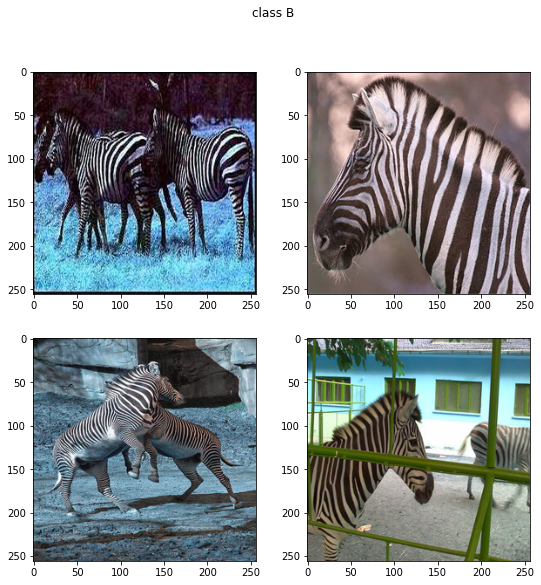

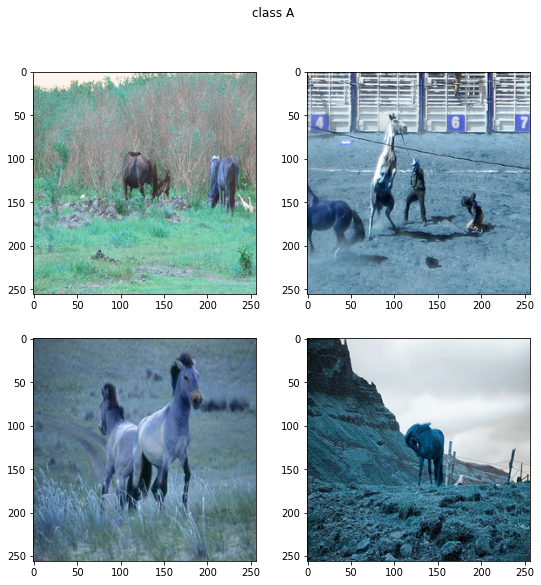

In [ ]:
batch = next(iter(train_dataloader))

def tensor2numpy(x):
  return x.permute(1,2,0).detach().cpu().numpy()

#class B
B = batch['B']
f, axarr = plt.subplots(2,2,figsize = (9,9))
axarr[0,0].imshow(tensor2numpy(B[0]))
axarr[0,1].imshow(tensor2numpy(B[1]))
axarr[1,0].imshow(tensor2numpy(B[2]))
axarr[1,1].imshow(tensor2numpy(B[3]))
f.suptitle("class B")
plt.show()
#class A
A = batch['A']
f, axarr = plt.subplots(2,2,figsize = (9,9))
axarr[0,0].imshow(tensor2numpy(A[0]))
axarr[0,1].imshow(tensor2numpy(A[1]))
axarr[1,0].imshow(tensor2numpy(A[2]))
axarr[1,1].imshow(tensor2numpy(A[3]))
f.suptitle("class A")
plt.show()

## Model Structure

In [ ]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

#
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks):
        super(GeneratorResNet, self).__init__()

        channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(channels),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
                      #2pad = k-2
            #model += [nn.ConvTranspose2d(in_features, out_features, kernel_size = 3, stride=2, padding=1, output_padding=1),
            model += [nn.ConvTranspose2d(in_features, out_features, kernel_size = 4, stride=2, padding=1),
                      nn.InstanceNorm2d(out_features),
                      nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

#discriminate on 16x16
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, height, width = input_shape

        # Calculate output shape of image discriminator (PatchGAN)
        self.output_shape = (1, height // 2 ** 4, width // 2 ** 4)

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )

    def forward(self, img):
        return self.model(img)

In [ ]:
class cycle_gan(nn.Module):
  # TODO: def a feed forward function to avoid code redundency 
  def __init__(self,input_shape):
      super(cycle_gan,self).__init__()
      self.G_AB = GeneratorResNet(input_shape,n_residual_blocks).cuda()
      self.G_BA = GeneratorResNet(input_shape,n_residual_blocks).cuda()
      self.D_A = Discriminator(input_shape).cuda()
      self.D_B = Discriminator(input_shape).cuda()
      #optimizers
      self.optimizer_G = torch.optim.Adam(
      itertools.chain(self.G_AB.parameters(), self.G_BA.parameters()), lr=lr, betas=(b1, b2)
    )
      self.optimizer_D_A = torch.optim.Adam(self.D_A.parameters(), lr=lr, betas=(b1, b2))
      self.optimizer_D_B = torch.optim.Adam(self.D_B.parameters(), lr=lr, betas=(b1, b2))
      # Buffers of previously generated samples
      self.fake_A_buffer = ReplayBuffer()
      self.fake_B_buffer = ReplayBuffer()
      #lr scheduler
      def lambda_rule(epoch):
          lr_l = 1.0 - max(0, epoch - epoch_n) / float(epoch_decrease_rate + 1)
          return lr_l
      self.G_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer_G, lr_lambda=lambda_rule)
      self.D_A_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_A, lr_lambda=lambda_rule)
      self.D_B_scheduler = torch.optim.lr_scheduler.LambdaLR(self.optimizer_D_B, lr_lambda=lambda_rule)
      #loss
      self.criterion_GAN = torch.nn.MSELoss().cuda()
      self.criterion_cycle = torch.nn.L1Loss().cuda()
      self.criterion_identity = torch.nn.L1Loss().cuda()
      if epoch_start != 0:
          # Load pretrained models
          print("loading weights from folder {}".format(pretrained_model_path))
          self.G_AB.load_state_dict(torch.load(f"{pretrained_model_path}/G_AB.pth"))
          self.G_BA.load_state_dict(torch.load(f"{pretrained_model_path}/G_BA.pth"))
          self.D_A.load_state_dict(torch.load(f"{pretrained_model_path}/D_A.pth"))
          self.D_B.load_state_dict(torch.load(f"{pretrained_model_path}/D_B.pth"))
          self.optimizer_G.load_state_dict(torch.load(f"{pretrained_model_path}/opt_G.pth"))
          self.optimizer_D_A.load_state_dict(torch.load(f"{pretrained_model_path}/opt_D_A.pth"))
          self.optimizer_D_B.load_state_dict(torch.load(f"{pretrained_model_path}/opt_D_B.pth"))
          self.G_scheduler.load_state_dict(torch.load(f"{pretrained_model_path}/G_scheduler.pth"))
          self.D_A_scheduler.load_state_dict(torch.load(f"{pretrained_model_path}/D_A_scheduler.pth"))
          self.D_B_scheduler.load_state_dict(torch.load(f"{pretrained_model_path}/D_B_scheduler.pth"))
      else:
          # Initialize weights
          self.G_AB.apply(weights_init_normal)
          self.G_BA.apply(weights_init_normal)
          self.D_A.apply(weights_init_normal)
          self.D_B.apply(weights_init_normal)
  def train_step(self,batch):
      Tensor = torch.cuda.FloatTensor
      # Set model input
      real_A = Variable(batch["A"].type(Tensor))
      real_B = Variable(batch["B"].type(Tensor))
      valid = Variable(Tensor(np.ones((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)
      fake = Variable(Tensor(np.zeros((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)
      ### Train Generators
      self.G_AB.train()
      self.G_BA.train()
      self.optimizer_G.zero_grad()
      # Identity loss
      loss_id_A = self.criterion_identity(self.G_BA(real_A), real_A)
      loss_id_B = self.criterion_identity(self.G_AB(real_B), real_B)
      loss_identity = (loss_id_A + loss_id_B) / 2
      # GAN loss
      fake_B = self.G_AB(real_A)
      loss_GAN_AB = self.criterion_GAN(self.D_B(fake_B), valid)
      fake_A = self.G_BA(real_B)
      loss_GAN_BA = self.criterion_GAN(self.D_A(fake_A), valid)
      loss_GAN = (category_B_weight*loss_GAN_AB + category_A_weight*loss_GAN_BA) / (category_A_weight+category_B_weight)
      # Cycle loss
      recov_A = self.G_BA(fake_B)
      loss_cycle_A = self.criterion_cycle(recov_A, real_A)
      recov_B = self.G_AB(fake_A)
      loss_cycle_B = self.criterion_cycle(recov_B, real_B)
      loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
      # Total loss
      loss_G = lambda_id * loss_identity + loss_GAN + lambda_cyc * loss_cycle
      loss_G.backward()
      self.optimizer_G.step()
      ### Train Discriminator-A
      self.D_A.train()
      self.optimizer_D_A.zero_grad()
      # Real loss
      loss_real = self.criterion_GAN(self.D_A(real_A), valid)
      # Fake loss (on batch of previously generated samples)
      fake_A_ = self.fake_A_buffer.push_and_pop(fake_A.detach())
      loss_fake = self.criterion_GAN(self.D_A(fake_A_.detach()), fake)
      # Total loss
      loss_D_A = (loss_real + loss_fake) / 2
      loss_D_A.backward()
      self.optimizer_D_A.step()
      ### Train Discriminator-B
      self.D_B.train()
      self.optimizer_D_B.zero_grad()
      # Real loss
      loss_real = self.criterion_GAN(self.D_B(real_B), valid)
      # Fake loss (on batch of previously generated samples)
      fake_B_ = self.fake_B_buffer.push_and_pop(fake_B.detach())
      loss_fake = self.criterion_GAN(self.D_B(fake_B_.detach()), fake)
      # Total loss
      loss_D_B = (loss_real + loss_fake) / 2
      loss_D_B.backward()
      self.optimizer_D_B.step()
      loss_D = (loss_D_A + loss_D_B) / 2
      return loss_G, loss_D
  def update_learning_rate(self):
      """Update learning rates for all the networks; called at the end of every epoch"""
      old_lr = self.optimizer_G.param_groups[0]['lr']
      self.G_scheduler.step()
      self.D_A_scheduler.step()
      self.D_B_scheduler.step()

      lr =  self.optimizer_G.param_groups[0]['lr']
      if old_lr != lr:
        print('learning rate %.7f -> %.7f' % (old_lr, lr))
  def save_model(self,epoch = "latest"):
      
      if type(epoch) == str:
          save_path = os.path.join(model_path,epoch)
      else:
          save_path = os.path.join(model_path,"epoch"+str(epoch))
      os.makedirs(save_path, exist_ok = True)
      torch.save(self.G_AB.state_dict(), os.path.join(save_path,"G_AB.pth"))
      torch.save(self.G_BA.state_dict(), os.path.join(save_path,"G_BA.pth"))
      torch.save(self.D_A.state_dict(), os.path.join(save_path,"D_A.pth"))
      torch.save(self.D_B.state_dict(), os.path.join(save_path,"D_B.pth"))
      torch.save(self.optimizer_G.state_dict(), os.path.join(save_path,"opt_G.pth"))
      torch.save(self.optimizer_D_A.state_dict(), os.path.join(save_path,"opt_D_A.pth"))
      torch.save(self.optimizer_D_B.state_dict(), os.path.join(save_path,"opt_D_B.pth"))
      torch.save(self.G_scheduler.state_dict(), os.path.join(save_path,"G_scheduler.pth"))
      torch.save(self.D_A_scheduler.state_dict(), os.path.join(save_path,"D_A_scheduler.pth"))
      torch.save(self.D_B_scheduler.state_dict(), os.path.join(save_path,"D_B_scheduler.pth"))
  def evaluate(self,dataloader,epoch):
      loss_gen = 0
      loss_disc = 0
      Tensor = torch.cuda.FloatTensor
      tqdm_bar = tqdm(dataloader, desc=f'Testing Epoch {epoch} ', total=int(len(dataloader)))
      self.fake_A_buffer = ReplayBuffer()
      self.fake_B_buffer = ReplayBuffer()
      with torch.no_grad():
          for batch_idx, batch in enumerate(tqdm_bar):
              # Set model input
              real_A = Variable(batch["A"].type(Tensor))
              real_B = Variable(batch["B"].type(Tensor))
              # Adversarial ground truths
              valid = Variable(Tensor(np.ones((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)
              fake = Variable(Tensor(np.zeros((real_A.size(0), *self.D_A.output_shape))), requires_grad=False)

              ### Test Generators
              self.G_AB.eval()
              self.G_BA.eval()
              # Identity loss
              loss_id_A = self.criterion_identity(self.G_BA(real_A), real_A)
              loss_id_B = self.criterion_identity(self.G_AB(real_B), real_B)
              loss_identity = (loss_id_A + loss_id_B) / 2
              # GAN loss
              fake_B = self.G_AB(real_A)
              loss_GAN_AB = self.criterion_GAN(self.D_B(fake_B), valid)
              fake_A = self.G_BA(real_B)
              loss_GAN_BA = self.criterion_GAN(self.D_A(fake_A), valid)
              loss_GAN = (category_B_weight*loss_GAN_AB + category_A_weight*loss_GAN_BA) / (category_A_weight+category_B_weight)
              # Cycle loss
              recov_A = self.G_BA(fake_B)
              loss_cycle_A = self.criterion_cycle(recov_A, real_A)
              recov_B = self.G_AB(fake_A)
              loss_cycle_B =self. criterion_cycle(recov_B, real_B)
              loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
              # Total loss
              loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
              ### Test Discriminator-A
              self.D_A.eval()
              # Real loss
              loss_real = self.criterion_GAN(self.D_A(real_A), valid)
              # Fake loss (on batch of previously generated samples)
              #fake_A_ = fake_A
              fake_A_ = self.fake_A_buffer.push_and_pop(fake_A.detach())
              loss_fake = self.criterion_GAN(self.D_A(fake_A_.detach()), fake)
              # Total loss
              loss_D_A = (loss_real + loss_fake) / 2

              ### Test Discriminator-B
              self.D_B.eval()
              # Real loss
              loss_real = self.criterion_GAN(self.D_B(real_B), valid)
              # Fake loss (on batch of previously generated samples)
              #fake_B_ = fake_B
              fake_B_ = self.fake_B_buffer.push_and_pop(fake_B.detach())
              loss_fake = self.criterion_GAN(self.D_B(fake_B_.detach()), fake)
              # Total loss
              loss_D_B = (loss_real + loss_fake) / 2
              loss_D = (loss_D_A + loss_D_B) / 2
              #add loss to average meter
              loss_gen += loss_G.item()
              loss_disc += loss_D.item()
              tqdm_bar.set_postfix(Gen_loss=loss_gen/(batch_idx+1),Disc_loss=loss_disc/(batch_idx+1))
      #fetch a new batch and do visualization
      fig = plt.figure(figsize=(32,32))
      for idx,batch in enumerate(dataloader):
        if idx>=4:
          break
        real_A = Variable(batch["A"].type(Tensor))
        real_B = Variable(batch["B"].type(Tensor))
        fake_B = self.G_AB(real_A)
        fake_A = self.G_BA(real_B)
        for i in range(batch_size):
          plt.subplot(8, 8, idx*16+i*4+1)
          plt.imshow(np.array(tensor2numpy(real_A[i])))
          plt.axis('off')
          plt.subplot(8, 8, idx*16+i*4+2)
          plt.imshow(np.array(tensor2numpy(fake_B[i])))
          plt.axis('off')    
          plt.subplot(8, 8, idx*16+i*4+3)
          plt.imshow(np.array(tensor2numpy(real_B[i])))
          plt.axis('off') 
          plt.subplot(8, 8, idx*16+i*4+4)
          plt.imshow(np.array(tensor2numpy(fake_A[i])))
          plt.axis('off')
      plt.savefig(os.path.join(image_path,'image_at_epoch_{:04d}.png'.format(epoch+1)))
      if epoch%save_frequency == 0:
        plt.show()   
        self.save_model(epoch)             
      plt.close(fig)
        
      return loss_gen/len(dataloader), loss_disc/len(dataloader)

## Training

In [ ]:
if epoch_start == 0:
  history = {"train_g_loss":[],"train_d_loss":[],"test_g_loss":[],"test_d_loss":[]}
  with open(os.path.join(model_path,"history.json"), 'w') as fp:
      json.dump(history, fp)

In [ ]:
input_shape = (channels,img_height,img_width)
model = cycle_gan(input_shape)
best_test_g_loss = np.inf
for epoch in range(epoch_start, n_epochs):
  epoch_loss_g = 0
  epoch_loss_d = 0
  with open(os.path.join(model_path,"history.json"), 'r') as fp:
      history = json.load(fp)
  tqdm_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch} ', total=int(len(train_dataloader)))
  for batch_idx, batch in enumerate(tqdm_bar):
    loss_G, loss_D = model.train_step(batch)
    loss_G = loss_G.item()
    loss_D = loss_D.item()
    epoch_loss_g += loss_G
    epoch_loss_d += loss_D
    tqdm_bar.set_postfix(Gen_loss=epoch_loss_g/(batch_idx+1),Disc_loss=epoch_loss_d/(batch_idx+1))
  epoch_loss_g = epoch_loss_g/len(train_dataloader)
  epoch_loss_d = epoch_loss_d/len(train_dataloader)
  history['train_g_loss'].append(epoch_loss_g)
  history['train_d_loss'].append(epoch_loss_d)
  loss_G, loss_D = model.evaluate(test_dataloader,epoch)
  history['test_g_loss'].append(loss_G)
  history['test_d_loss'].append(loss_D)
  if loss_G < best_test_g_loss:
    best_test_g_loss = loss_G
    model.save_model("best_test_loss")
  model.save_model("latest")
  model.update_learning_rate()
  with open(os.path.join(model_path,"history.json"), 'w') as fp:
      json.dump(history, fp)


In [ ]:
'''
For debug
'''
input_shape = (channels,img_height,img_width)
model = cycle_gan(input_shape)
model.evaluate(test_dataloader,0)

In [6]:
with open(os.path.join(model_path,"history.json"), 'r') as fp:
    history = json.load(fp)

In [8]:
history.keys()

dict_keys(['train_g_loss', 'train_d_loss', 'test_g_loss', 'test_d_loss'])

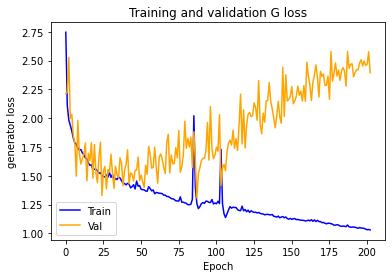

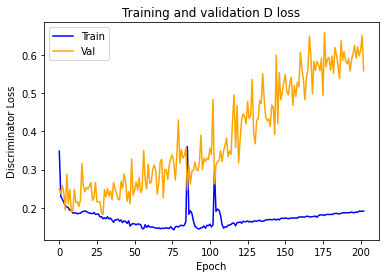

In [10]:
def plot(history):
  
  # The history object contains results on the training and test
  # sets for each epoch
  train_g_loss = history['train_g_loss']
  train_d_loss = history['train_d_loss']
  test_g_loss = history['test_g_loss']
  test_d_loss = history['test_d_loss']

  # Get the number of epochs
  epochs = range(len(train_g_loss))

  plt.title('Training and validation G loss')
  plt.plot(epochs, train_g_loss, color='blue', label='Train')
  plt.plot(epochs, test_g_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('generator loss')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation D loss')
  plt.plot(epochs, train_d_loss, color='blue', label='Train')
  plt.plot(epochs, test_d_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Discriminator Loss')
  plt.legend()
  
plot(history)